In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import itertools
import os
from shapely.geometry import Polygon
import h3
from sklearn.metrics.pairwise import cosine_similarity
import re
from sentence_transformers import SentenceTransformer
from geopy.distance import geodesic
from scipy.stats import norm
from sklearn.decomposition import TruncatedSVD

/home/zcemg08/projects/AIRFLOW_DATA_PROPERTIES/.rent_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Process Data for Travel Zones

Reference: [Can I get exact coordinates of London zones and use them in code?](https://stackoverflow.com/questions/45247439/can-i-get-exact-coordinates-of-london-zones-and-use-them-in-code)

```python
import zipfile

# Define file paths
kmz_file = "../data/external/London Transport Zone Map.kmz"
output_dir = "../data/external"

# Extract the KMZ file
with zipfile.ZipFile(kmz_file, 'r') as kmz:
    kmz.extractall(output_dir)


# Load Data 

In [2]:
df = pd.read_parquet("../data/processed/rent_london.parquet") # Apify data after EDA1
london_boundaries = gpd.read_file('../data/external/london_boroughs.geojson') # Downloaded from https://github.com/radoi90/housequest-data
london_stations = gpd.read_file("../data/external/london_stations.geojson")

output_dir = "../data/external"
kml_file = os.path.join(output_dir, 'doc.kml')
zone_fares = gpd.read_file(kml_file) #Load travel zones geometry
road_noize = gpd.read_file("../data/external/Road_LAeq_16h_London/Road_LAeq_16h_London.shp")# https://data.london.gov.uk/dataset/noise-pollution-in-london

Skipping field lines: unsupported OGR type: 5
/home/zcemg08/projects/AIRFLOW_DATA_PROPERTIES/.rent_env/lib/python3.10/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'doc.kml': 'Zones' (default), 'Zone 3 & 4 Stations', 'Zone 4 Stations', 'Zone 5 Stations', 'Zone 5 & 6 Stations', 'Zone 6 Stations', 'Zone 6 & 7 Stations', 'Zone 7 Stations', 'Zone 8 Stations', 'Zone 9 Stations'. Specify layer parameter to avoid this warning.
  result = read_func(


Merge external data with scrapped rental data

In [3]:
# Convert Pandas DataFrame to GeoPandas for spatial manipulation of the data
df["geometry"] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs(epsg=4326, inplace=True) 

# Merge spatialy with boroughs
gdf = gpd.sjoin(gdf, london_boundaries, how="left")
gdf = gdf.rename(columns={"name":"borough"})
gdf = gdf.drop("index_right",axis=1)

#Merge spatialy travel zones to properties
gdf = gpd.sjoin(gdf, zone_fares, how="left")
gdf = gdf.rename(columns={"Name":"zone"})
gdf = gdf.drop(columns=["index_right","Description"])

# only 21 places were NaNs
gdf = gdf[gdf["zone"].notna()]
gdf["zone"] = gdf["zone"].apply(lambda x: x.split(" ")[-1]) # remove zone word

# change road noize poligon coordinates to latitude and longitude
road_noize = road_noize.set_crs(epsg=27700, allow_override=True)
road_noize = road_noize.to_crs(epsg=4326)

### Latitude , Longitude feature engineering 

https://towardsdatascience.com/feature-engineering-with-latitude-and-longitude-2577b7ad7a45

In [4]:
def compute_angle(lat, lon, center_lat, center_lon):
    # Convert to radians
    lat1, lon1 = np.radians(center_lat), np.radians(center_lon)
    lat2, lon2 = np.radians(lat), np.radians(lon)
    
    # Vector difference
    dlon = lon2 - lon1
    x = np.cos(lat2) * np.sin(dlon)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    
    # Compute angle in radians and convert to degrees
    angle = np.arctan2(x, y)
    
    return angle


# Find distance to the city center 
city_center = (51.5072, -0.1276)
gdf["distance_to_center"] = gdf[["latitude","longitude"]].apply(lambda x: geodesic((x[0],x[1]), city_center).miles,axis=1)

# Find angle relative to city center
gdf['angle_from_center'] = gdf.apply(
    lambda row: compute_angle(row['latitude'], row['longitude'], city_center[0], city_center[1]), axis=1
)

/tmp/ipykernel_7578/2532253447.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gdf["distance_to_center"] = gdf[["latitude","longitude"]].apply(lambda x: geodesic((x[0],x[1]), city_center).miles,axis=1)


### Add hexagon data

https://h3-pandas.readthedocs.io/en/latest/notebook/00-intro.html#

In [5]:
def invert_coordinates(geometry):
    if isinstance(geometry, Polygon):
        # Invert coordinates in the polygon
        inverted_coords = [(y, x) for x, y in geometry.exterior.coords]
        return Polygon(inverted_coords)
    return geometry


def create_london_h3_index(london_boundaries):
    # Create a unified polygon of all London boroughs
    london_polygon = london_boundaries.union_all()
    
    # Define the resolution for the hexagons
    resolution = 9  # Adjust resolution as needed -> hexgon with circle inside radius = 348m
    
    # Generate hexagons that cover the London polygon
    hexagons = h3.polyfill(london_polygon.__geo_interface__, res=resolution)
    
    # Function to convert hex ID to polygon geometry
    def hex_to_polygon(hex_id):
        boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
        return Polygon(boundary)
    
    # Create a DataFrame with hex IDs and their corresponding geometries
    hex_data = {
        "hex_id": list(hexagons),
        "geometry": [hex_to_polygon(h) for h in hexagons]
    }
    
    # Convert DataFrame to GeoDataFrame
    hex_df = pd.DataFrame(hex_data)
    hex_gdf = gpd.GeoDataFrame(hex_df, geometry='geometry')
    
    return hex_gdf


hex_gdf = create_london_h3_index(london_boundaries)
hex_gdf = hex_gdf.set_crs("EPSG:4326", allow_override=True)
hex_gdf['geometry'] = hex_gdf['geometry'].apply(invert_coordinates)

h3_noize = gpd.sjoin(hex_gdf, road_noize, how="left")
h3_noize = h3_noize.drop("index_right",axis=1)
h3_noize["NoiseClass"] = h3_noize["NoiseClass"].fillna("0")

new_df = h3_noize[["hex_id","NoiseClass"]].groupby("hex_id").agg("max").reset_index()
hex_gdf = pd.merge(hex_gdf,new_df,how="left",on="hex_id")


hex_zone = gpd.sjoin(hex_gdf, zone_fares, how="left")
hex_zone = hex_zone.drop(columns=["NoiseClass","index_right", "Description"],axis=1)
hex_zone = hex_zone.rename(columns={"Name":"zone_hex"})
hex_zone = hex_zone[["hex_id","zone_hex"]].groupby("hex_id").agg("min").reset_index()
hex_gdf  = pd.merge(hex_gdf,hex_zone,how="left",on="hex_id")

# merge hexagons to properties

gdf = gpd.sjoin(gdf, hex_gdf, how="left")

In [6]:
gdf.head(2)

,title,displayAddress,outcode,incode,bathrooms,bedrooms,propertyType,price,secondaryPrice,letAvailableDate,...,geometry,borough,color,zone,distance_to_center,angle_from_center,index_right,hex_id,NoiseClass,zone_hex
id,,,,,,,,,,,,,,,,,,,,,
154825190,"3 bedroom house for rent in Novello Street, Pa...","Novello Street, Parsons Green, London, SW6",SW6,4JB,2.0,3.0,House,18633,4300,Ask agent,...,POINT (-0.19944 51.47583),Hammersmith and Fulham,blue,2,3.783423,-2.181945,23180.0,897b810d583ffff,55.0-59.9,Zone 2
155893427,"4 bedroom house for rent in Studdridge Street,...","Studdridge Street, Fulham, London, SW6",SW6,3SL,4.0,4.0,House,13000,3000,Ask agent,...,POINT (-0.19348 51.4721),Hammersmith and Fulham,blue,2,3.738045,-2.278172,13914.0,897b810d517ffff,0,Zone 2


In [7]:
gdf = gdf[gdf["NoiseClass"].notna()]
gdf["NoiseClass"].value_counts()

NoiseClass
0            9139
>=75.0       8641
70.0-74.9    8585
55.0-59.9    1665
60.0-64.9    1115
65.0-69.9     902
Name: count, dtype: int64

In [8]:
# Quick overview over float variables 

gdf.describe()

,bathrooms,bedrooms,price,secondaryPrice,sizeSqFeetMin,sizeSqFeetMax,latitude,longitude,distance_to_station1,distance_to_station2,distance_to_station3,distance_to_center,angle_from_center,index_right
count,30047.000000,28736.000000,30047.000000,30047.000000,30047.00000,30047.000000,30047.000000,30047.000000,30047.000000,30047.000000,30046.000000,30047.000000,30047.000000,30047.000000
mean,1.586082,2.187952,4057.624022,936.386162,388.49356,388.592339,51.506645,-0.141006,0.338379,0.554688,0.707031,5.190891,-0.326470,14089.772689
std,1.103043,1.193683,6147.707730,1418.698974,964.31847,964.369968,0.053846,0.113412,0.916504,0.927734,0.735840,3.344032,1.739438,8050.768609
min,1.000000,1.000000,400.000000,92.000000,0.00000,0.000000,51.299250,-0.488402,0.000000,0.006222,0.038788,0.001302,-3.141539,3.000000
25%,1.000000,1.000000,1950.000000,450.000000,0.00000,0.000000,51.481428,-0.195901,0.165283,0.338623,0.458252,2.489829,-1.839484,7225.000000
50%,1.000000,2.000000,2700.000000,623.000000,0.00000,0.000000,51.507900,-0.149384,0.269775,0.478027,0.619629,4.433393,-0.760838,14520.000000
75%,2.000000,3.000000,4117.000000,950.000000,651.00000,652.000000,51.537703,-0.072680,0.421631,0.663574,0.839844,7.265569,1.329335,20871.000000
max,111.000000,60.000000,216667.000000,50000.000000,66004.00000,66004.000000,51.683330,0.267228,106.500000,107.062500,106.062500,17.539355,3.141496,27574.000000


1. Some dodgy numbers for the distances in miles to 3 nearest stations , bathrooms, bedrooms
2. Rent price of the 25th percentile is close to my previos job salary after tax ... 😔

Text(0, 0.5, 'Fraction')

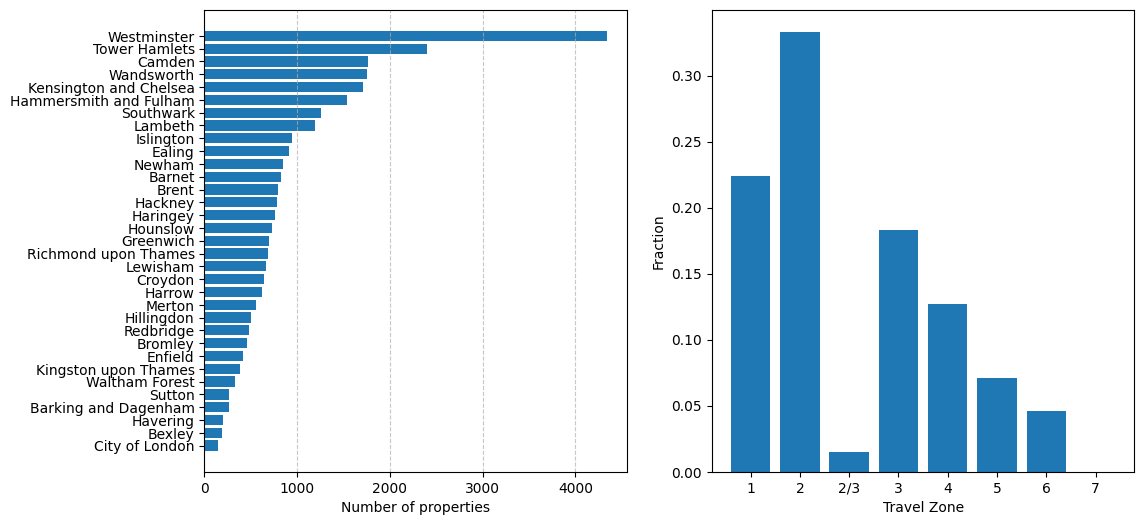

In [9]:
zone_demand = gdf.groupby("zone").agg("count")["title"].reset_index().rename({"title":"count"},axis=1)
zone_demand["count"] = zone_demand["count"]/len(gdf)
boroughs_demand = gdf.groupby("borough").agg("count")["title"].reset_index().rename({"title":"count"},axis=1).sort_values(by="count",ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

axes[0].barh(boroughs_demand["borough"], boroughs_demand["count"])
axes[0].grid(True, axis='x', linestyle='--', alpha=0.7)
axes[0].set_xlabel("Number of properties")

axes[1].bar(zone_demand["zone"], zone_demand["count"])
axes[1].set_xlabel('Travel Zone')
axes[1].set_ylabel('Fraction')


In [10]:
(gdf["bedrooms"]>8).sum(), (gdf["bathrooms"]>6).sum() # outliers in bedrooms, bathrooms

(11, 61)

In [11]:
gdf['borough'].isna().sum()  # outliers in borough

3

In [12]:
gdf = gdf[gdf["borough"].notna()]

In [13]:
gdf[gdf["bedrooms"].isna()]["propertyType"].value_counts()

propertyType
Studio    1311
Name: count, dtype: int64

In [14]:
gdf["bedrooms"] = gdf["bedrooms"].fillna(1)

In [15]:
# convert bedrooms and bathrooms as integers, might be usefull for Neural Networks to treat as categorical variables
gdf[['bedrooms', 'bathrooms']] = gdf[['bedrooms', 'bathrooms']].astype(int)

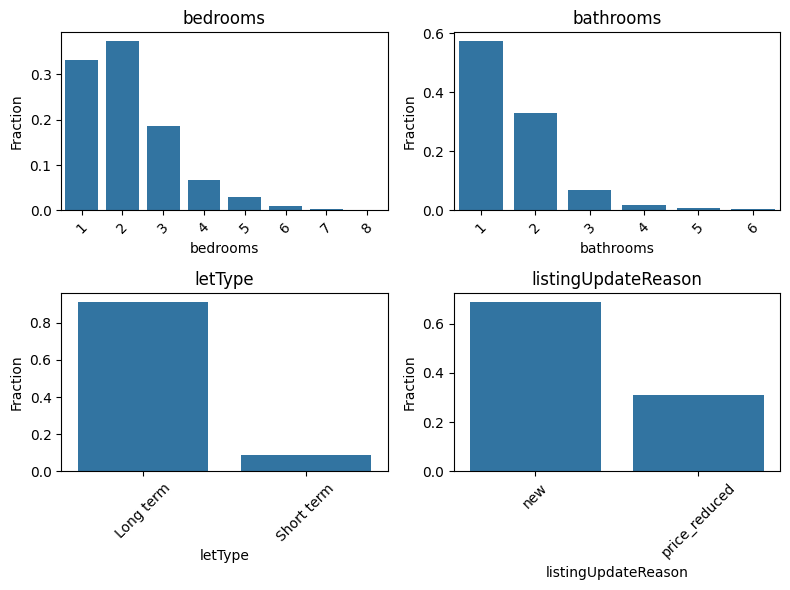

In [16]:
# Types of housing and contracts

gdf = gdf[(gdf["bedrooms"]<=8) & (gdf["bathrooms"]<=6)] # remove above outliers

categorical_features = ['bedrooms', 'bathrooms', 'letType', 'listingUpdateReason']

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for i, column in enumerate(categorical_features):
    value_counts = gdf[column].value_counts(normalize=True).reset_index()
    value_counts.columns = [column, 'fraction']
    sns.barplot(data=value_counts, x=column, y='fraction', ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Fraction')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [17]:
"Properies that specify deposit = {} %".format(round((gdf["deposit"]==True).sum()/len(gdf)*100))

'Properies that specify deposit = 74 %'

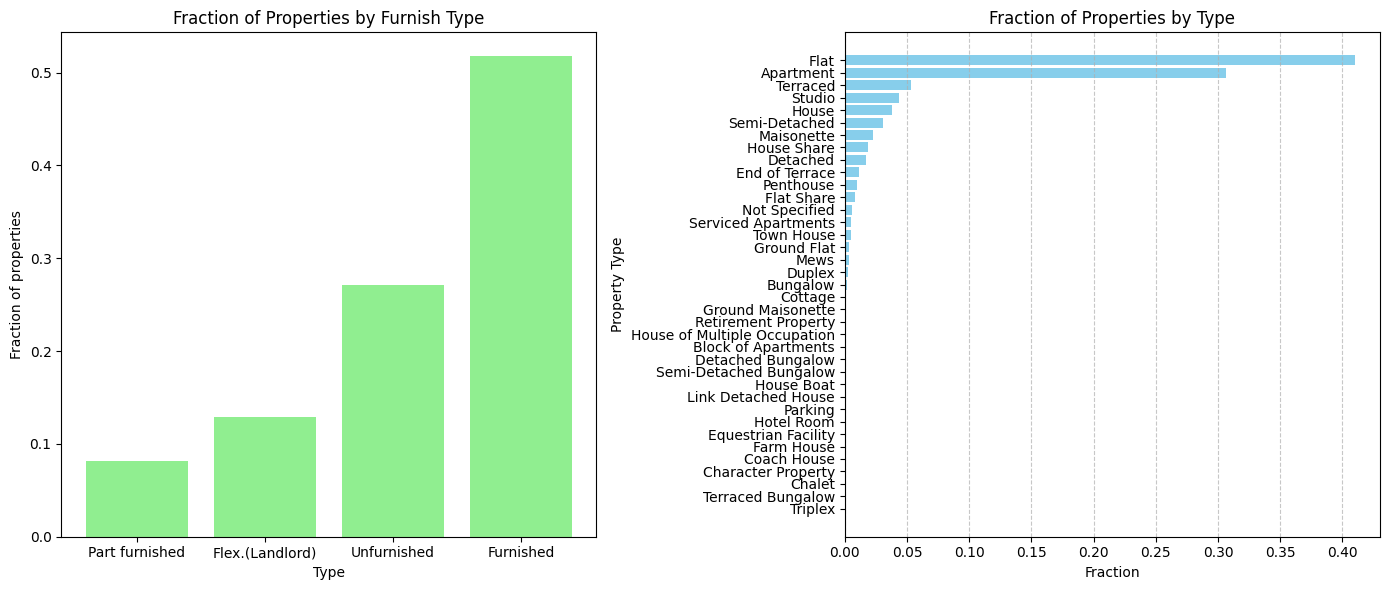

In [18]:
# Where people live

furnish = gdf[gdf["furnishType"].notna()].groupby("furnishType").agg("count")["title"].reset_index().rename({"title":"count"},axis=1)
furnish = furnish.sort_values("count",ascending=True)
furnish.loc[1, "furnishType"] = "Flex.(Landlord)"
furnish["furnish_normilized"] = furnish["count"]/len(gdf[gdf["furnishType"].notna()])

prop_types = gdf.groupby("propertyType").agg("count")["title"].reset_index().rename({"title":"count"},axis=1)
prop_types = prop_types.sort_values(by="count",ascending=True)
prop_types["count_normilized"] = prop_types["count"]/len(gdf)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for furnishing types
axes[0].bar(furnish["furnishType"], furnish["furnish_normilized"], color='lightgreen')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Fraction of properties')
axes[0].set_title('Fraction of Properties by Furnish Type')


# Plot for property types
axes[1].barh(prop_types["propertyType"], prop_types["count_normilized"], color='skyblue')
axes[1].set_xlabel('Fraction')
axes[1].set_ylabel('Property Type')
axes[1].grid(True, axis='x', linestyle='--', alpha=0.7)
axes[1].set_title('Fraction of Properties by Type')

plt.tight_layout()
plt.show()

In [19]:
# reduce cardinality of the propety types, based on the above plot 

accepted_pr_types = ["Flat","Apartment","Terraced","House","Semi-Detached","Maisonette","House Share","Detached", "End of Terrace","Penthouse","Flat Share"]
gdf["propertyType"] = gdf["propertyType"].apply(lambda x: x if x in accepted_pr_types else "other")

### Transport Access

In [20]:
(gdf["distance_to_station1"]>1).sum(),(gdf["distance_to_station1"]>2).sum() # outliers for the distances to the nearest station

(547, 70)

In [21]:
gdf = gdf[gdf["distance_to_station1"]<=2] #  remove outliers

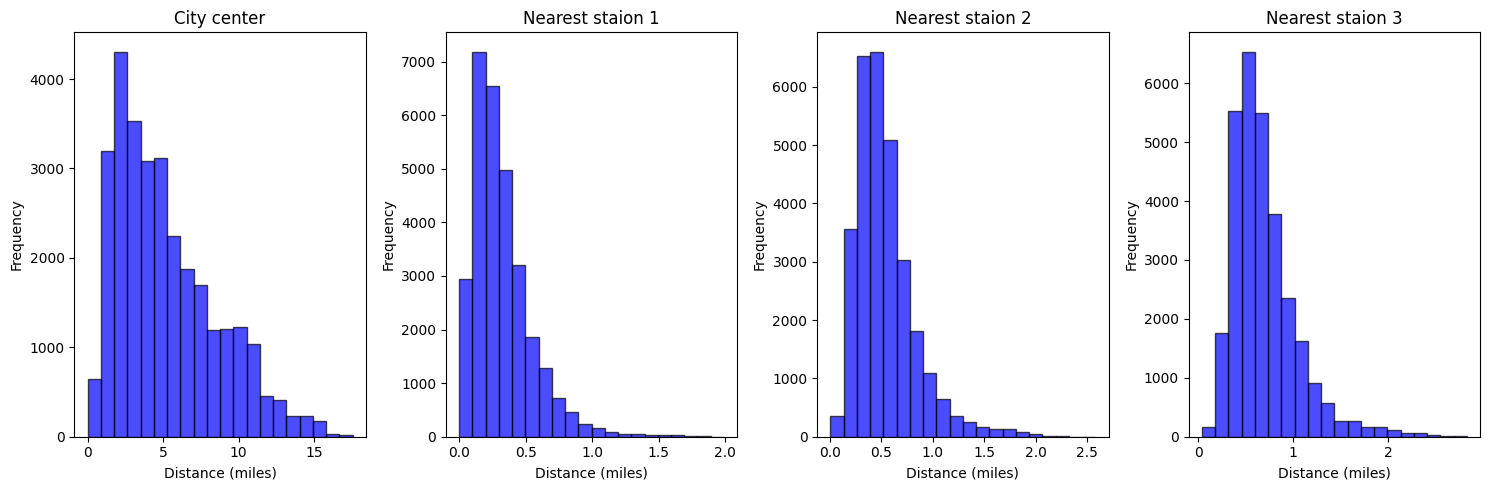

In [22]:
# Distributions to the city center and three nearest train/u-bahn stations for each data point 

distances = ["distance_to_center","distance_to_station1",	"distance_to_station2",	"distance_to_station3"]	

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, column in enumerate(distances):
    axes[i].hist(gdf[column], bins=20, color='blue', edgecolor='black', alpha=0.7)
    
    if i >0:
        axes[i].set_title(f"Nearest staion {i}")
        axes[i].set_xlabel('Distance (miles)')
        axes[i].set_ylabel('Frequency')
        
    else:
        axes[i].set_title(f"City center")
        axes[i].set_xlabel('Distance (miles)')
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [23]:
all_station_types = set(list(itertools.chain.from_iterable(gdf['station_type1'])))
print(all_station_types)  

{'NATIONAL_TRAIN', 'LIGHT_RAILWAY', 'LONDON_OVERGROUND', 'LONDON_UNDERGROUND', 'CABLE_CAR', 'TRAM'}


In [24]:
# 50 unique station names per one property in the dataset

len(gdf["station_name1"].unique()),len(gdf["station_name2"].unique()),len(gdf["station_name3"].unique()), len(gdf)/len(gdf["station_name1"].unique())

(607, 624, 628, 49.27018121911038)

In [25]:
stations_popularity = gdf.groupby("station_name1").agg("count")["title"].reset_index().rename(columns={"title":"count","station_name1":"station_name"}).sort_values("count",ascending=False)
stations_popularity.head(5)

,station_name,count
465,South Kensington Station,581
482,St. John's Wood Station,497
166,Edgware Road (Bakerloo) Station,481
456,Sloane Square Station,401
278,Imperial Wharf Station,390


Text(0, 0.5, 'Proportion of properties')

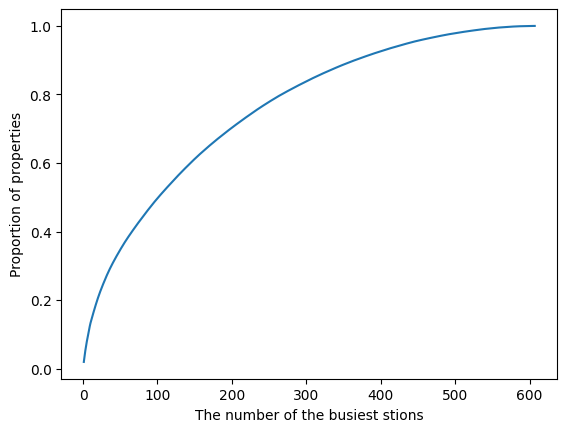

In [26]:
# Calculate cumulative count
stations_popularity['cumulative_count'] = stations_popularity['count'].cumsum()/len(gdf)
plt.plot(range(1,len(stations_popularity)+1),stations_popularity["cumulative_count"])
plt.xlabel("The number of the busiest stions")
plt.ylabel("Proportion of properties")

In [27]:
# reduce cardinality of the station types

station_map = {"LONDON_UNDERGROUND":"TFL",
               "LIGHT_RAILWAY":"TFL",
               "CABLE_CAR":"TFL",
               "LONDON_OVERGROUND":"TFL"}

def reduce_cardinality_station_type(x:list)->list:
    
    new_list = [station_map[y] if y in station_map.keys() else y  for y in x]
    
    return list(set(new_list))

gdf["station_type1"] = gdf["station_type1"].apply(reduce_cardinality_station_type)
gdf["station_type2"] = gdf["station_type2"].apply(reduce_cardinality_station_type)
gdf["station_type3"] = gdf["station_type3"].apply(reduce_cardinality_station_type)

In [28]:
station_types = ['station_type1', 'station_type2', 'station_type3']
keywords = {'TFL': 'TFL', 'RAIL': 'NATIONAL_TRAIN'}

for keyword, term in keywords.items():
    for station_type in station_types:
        gdf[f"{keyword}{station_types.index(station_type) + 1}"] = gdf[station_type].apply(lambda x: term in x)

### Target distribution (EDA on this topic will expand later)

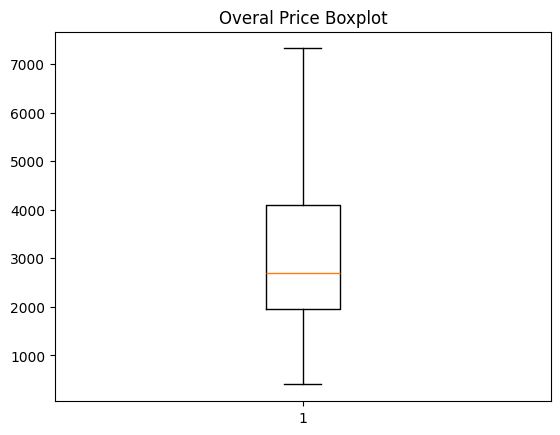

In [29]:
plt.boxplot(gdf["price"],showfliers=False)
plt.title("Overal Price Boxplot")
plt.show()

# Spatial Vizualisations

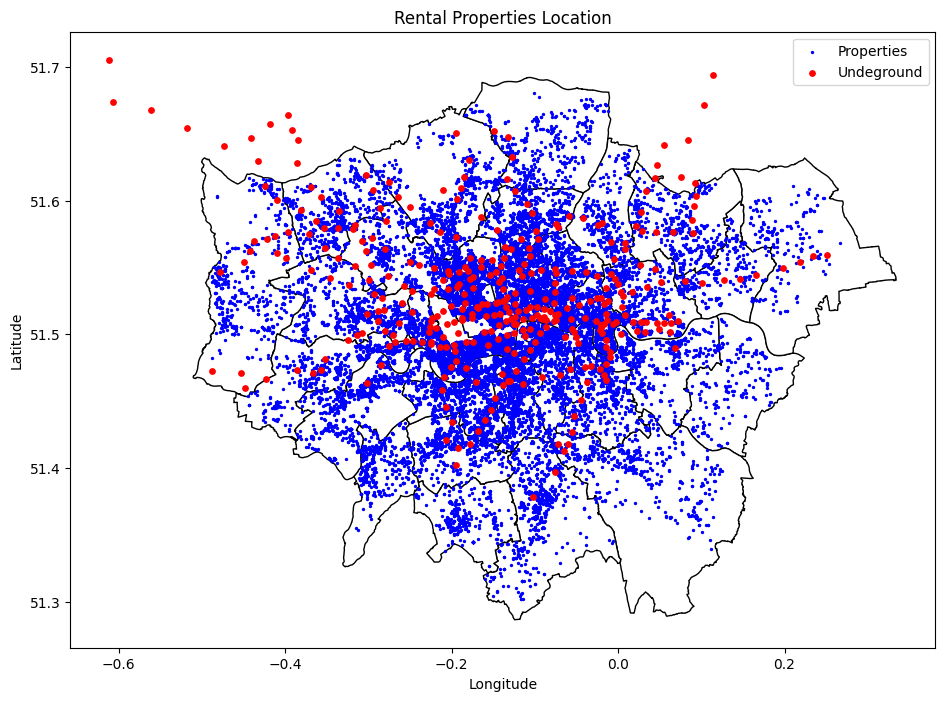

In [30]:
plt.figure(figsize=(12, 8))

london_boundaries.plot(ax=plt.gca(),  color='white', edgecolor='black')
gdf.plot(ax=plt.gca(), color='blue',markersize=2,label="Properties")
london_stations.plot(ax=plt.gca(), color='red',markersize=15, label="Undeground")

plt.title('Rental Properties Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.savefig("../images/map_check.png")
plt.show()

/home/zcemg08/projects/AIRFLOW_DATA_PROPERTIES/.rent_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


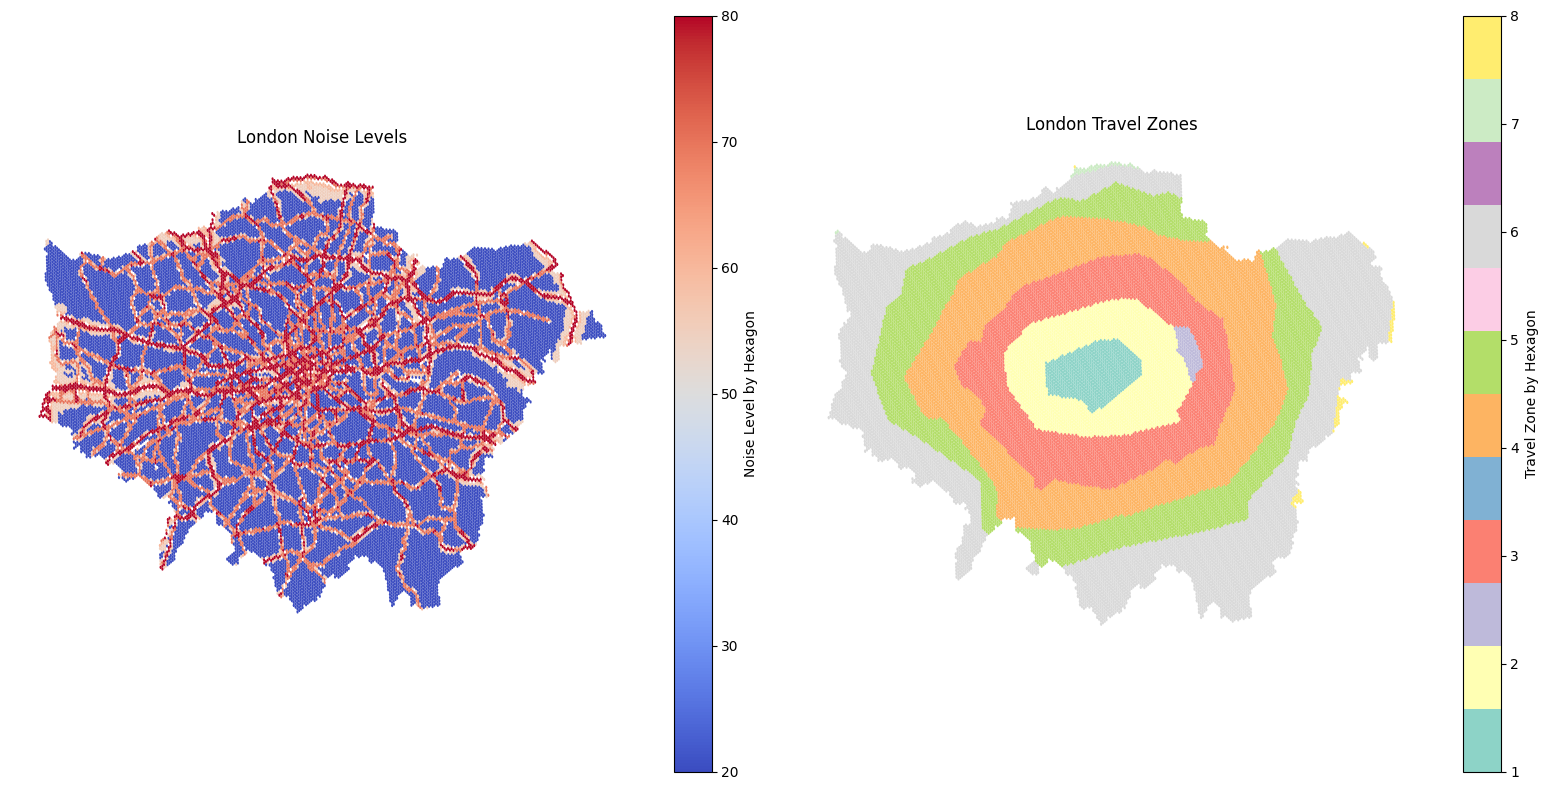

In [30]:
# hexagons data 

def plot_hexagone_data(hex_gdf):

    noise_mapping = {
        "0": 20,
        '50.0-54.9': 50,
        '55.0-59.9': 55,
        '60.0-64.9': 60,
        '70.0-74.9': 70,
        '>=75.0': 80,
    }
    
    zone_mapping = {
        "Zone 1": 1,
        "Zone 2": 2,
        "Zone 3": 3,
        "Zone 4": 4,
        "Zone 5": 5,
        "Zone 6": 6,
        "Zone 7": 7,
        "Zone 8": 8,
        "Zone 2/3": 2.5,
    }
    
    # Filter out rows with missing zone data
    hex_zone = hex_gdf[hex_gdf["zone_hex"].notna()]
    
    # Map Travel Zone and NoiseClass to numeric values
    hex_zone["Travel_zone_numeric"] = hex_zone["zone_hex"].map(zone_mapping)
    hex_gdf['NoiseClass_numeric'] = hex_gdf['NoiseClass'].map(noise_mapping)

    # Ensure that the data has no NaN values for plotting
    hex_gdf = hex_gdf.dropna(subset=['NoiseClass_numeric'])

    # Create subplots (2 subplots side by side)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot Noise Levels in the first subplot
    hex_gdf.plot(column='NoiseClass_numeric', cmap='coolwarm', ax=axes[0], legend=True,
                 legend_kwds={'label': "Noise Level by Hexagon", 'orientation': "vertical"})
    axes[0].set_title("London Noise Levels")
    axes[0].set_axis_off()  # Remove axis lines

    # Plot Travel Zones in the second subplot
    hex_zone.plot(column='Travel_zone_numeric', cmap='Set3', ax=axes[1], legend=True,
                  legend_kwds={'label': "Travel Zone by Hexagon", 'orientation': "vertical"})
    axes[1].set_title("London Travel Zones")
    axes[1].set_axis_off()  # Remove axis lines

    # Show the plot
    plt.tight_layout()
    plt.savefig("../images/hexagons.png")
    plt.show()

# Call the function with your hex_gdf data
plot_hexagone_data(hex_gdf)


## Text procesings 

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

### It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

In [31]:
from nltk.tokenize import PunktSentenceTokenizer


def simple_text_clean(text):
      
    url_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    re.sub(url_pattern, "", text)
    
    tokenizer_sentences = PunktSentenceTokenizer()
    # Define the list of boilerplate phrases
    boilerplate_phrases = [
          "contact", "for more info", "call", "viewings","visit",
          "arrange", "available now", "great investment", "schedule",
          "agent", "short let", "long let", "terms","income","photo","please note"]

    # Tokenize the text into sentences
    sentences = tokenizer_sentences.tokenize(text)
    
    # Remove sentences containing boilerplate phrases
    cleaned_sentences = [sentence for sentence in sentences if not any(phrase in sentence.lower() for phrase in boilerplate_phrases)]
    
    return "\n".join(cleaned_sentences)

In [32]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def clean_text(text):
    # Remove reference codes
    text = re.sub(r"Please use the reference\s+[A-Za-z0-9]+.*", "", text)
    # Further text cleaning if needed (e.g., remove special characters)
    return text.strip()

# Clean each description
gdf['clean_description'] = gdf['description'].apply(simple_text_clean)

# Encode the cleaned descriptions in batches
gdf['embeddings'] = model.encode(gdf['clean_description'].tolist(), batch_size=64, show_progress_bar=True).tolist()

# Convert embeddings to matrix
embed_matrix = np.vstack([np.array(gdf["embeddings"].values[x]) for x in range(len(gdf))])

# Compute cosine
cos_sim_matrix = cosine_similarity(embed_matrix)

# Assign index for quick retriviel of the data basewd on simmilarity matrix row index
gdf["index_rows"] = list(range(len(gdf)))

Batches: 100%|██████████| 468/468 [01:14<00:00,  6.25it/s]


In [33]:
embeddings_lengths = np.linalg.norm(embed_matrix,axis=1)

print(embeddings_lengths.mean(),embeddings_lengths.var()) # embed vectors normilized

0.9999999997306334 1.0455617779687337e-15


In [34]:
cos_sim_matrix.dtype

dtype('float64')

In [35]:
cos_sim_matrix = cos_sim_matrix.astype(np.float32)


In [ ]:
from scipy.sparse import csr_matrix
mask = np.triu(np.ones(cos_sim_matrix.shape, dtype=bool), k=1)
cos_sim_sparse = csr_matrix(cos_sim_matrix * mask)


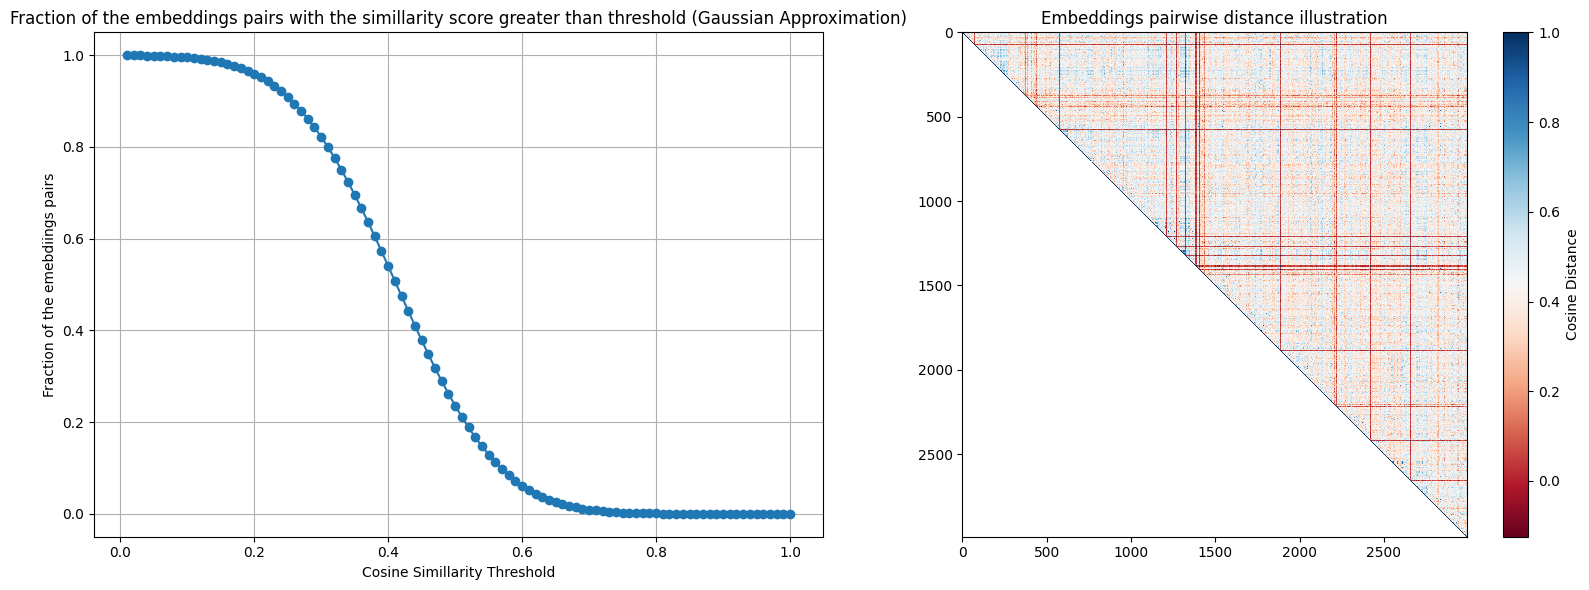

In [35]:
# Calculate mean and standard deviation
mean = np.mean(cos_sim_matrix)
std_dev = np.std(cos_sim_matrix)

# Generate thresholds from 0.01 to 1 with a step of 0.01
thresholds = np.arange(0.01, 1.01, 0.01)

# Calculate the cumulative probability for values greater than each threshold
cumulative_proportions = [1 - norm.cdf(threshold, loc=mean, scale=std_dev) for threshold in thresholds]

# Downsample the cosine similarity matrix
downsample_rate = 10  # Adjust this to control the downsampling
reduced_matrix = cos_sim_matrix[::downsample_rate, ::downsample_rate]

# Mask the lower triangle of the reduced matrix
mask = np.triu(np.ones_like(reduced_matrix, dtype=bool))

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Cumulative Proportion Plot
axs[0].plot(thresholds, cumulative_proportions, marker='o')
axs[0].set_title('Fraction of the embeddings pairs with the simillarity score greater than threshold (Gaussian Approximation)')
axs[0].set_xlabel('Cosine Simillarity Threshold')
axs[0].set_ylabel('Fraction of the emebdiings pairs')
axs[0].grid(True)

# Second subplot: Downsampled Matrix Plot
cax = axs[1].imshow(np.where(mask, reduced_matrix, np.nan), cmap='RdBu', interpolation='none')
axs[1].set_title('Embeddings pairwise distance illustration')
fig.colorbar(cax, ax=axs[1], label='Cosine Distance')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Calculate mean and standard deviation
mean = np.mean(cos_sim_matrix)
std_dev = np.std(cos_sim_matrix)

# Generate thresholds from 0.01 to 1 with a step of 0.01
thresholds = np.arange(0.01, 1.01, 0.01)

# Calculate the cumulative probability for values greater than each threshold
cumulative_proportions = [1 - norm.cdf(threshold, loc=mean, scale=std_dev) for threshold in thresholds]

# Downsample the cosine similarity matrix
downsample_rate = 10  # Adjust this to control the downsampling
reduced_matrix = cos_sim_matrix[::downsample_rate, ::downsample_rate]

# Mask the lower triangle of the reduced matrix
mask = np.triu(np.ones_like(reduced_matrix, dtype=bool))

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Cumulative Proportion Plot
axs[0].plot(thresholds, cumulative_proportions, marker='o')
axs[0].set_title('Fraction of the embeddings pairs with the simillarity score greater than threshold (Gaussian Approximation)')
axs[0].set_xlabel('Cosine Simillarity Threshold')
axs[0].set_ylabel('Fraction of the emebdiings pairs')
axs[0].grid(True)

# Second subplot: Downsampled Matrix Plot
cax = axs[1].imshow(np.where(mask, reduced_matrix, np.nan), cmap='RdBu', interpolation='none')
axs[1].set_title('Embeddings pairwise distance illustration')
fig.colorbar(cax, ax=axs[1], label='Cosine Distance')

# Display the plots
plt.tight_layout()
plt.show()

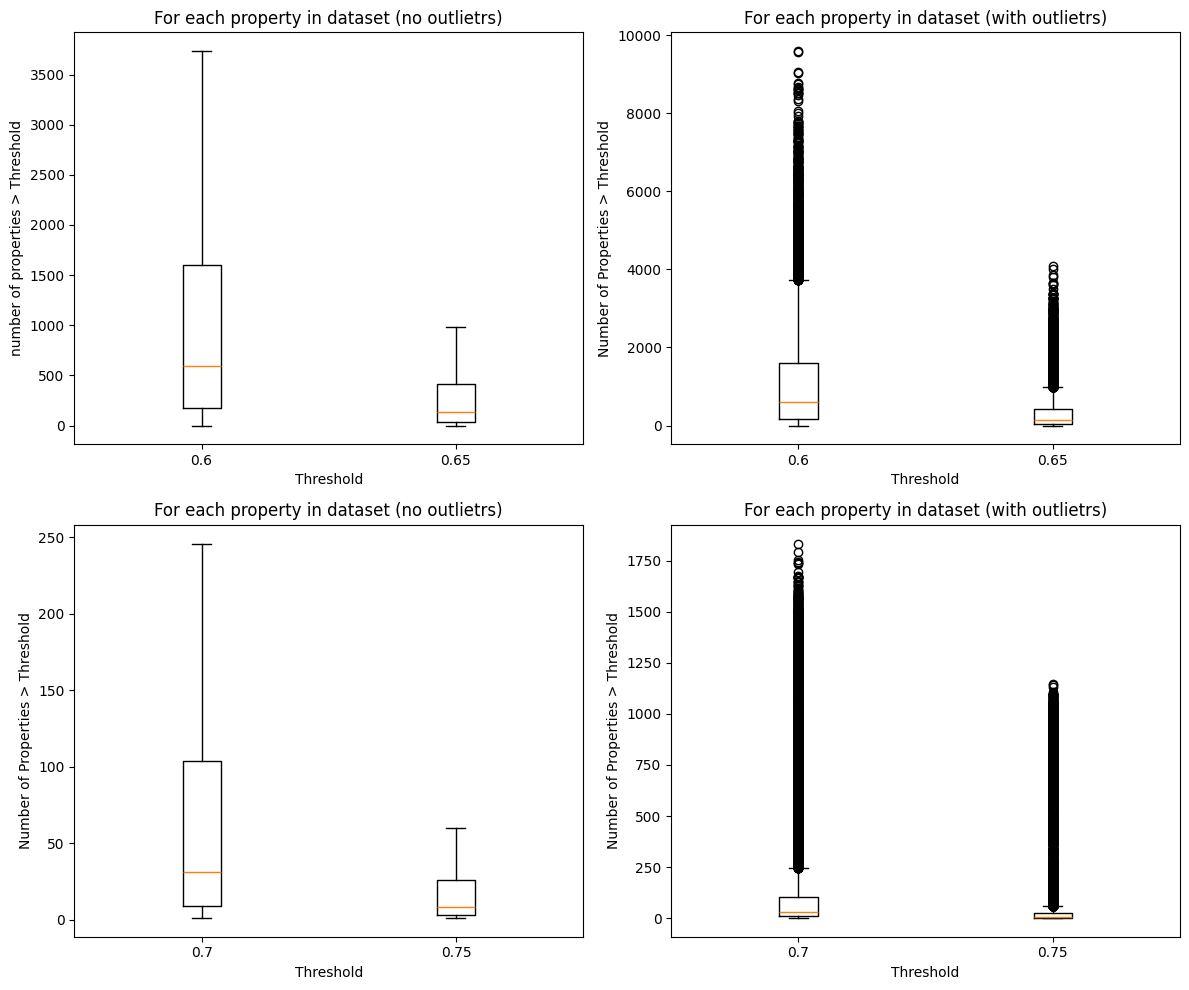

In [35]:
# Function to compute the number of values above each threshold
def compute_n_closest(cos_sim_matrix, thresholds):
    results = {}
    for threshold in thresholds:
        results[threshold] = [(cos_sim_matrix[x, :] > threshold).sum() for x in range(len(cos_sim_matrix))]
    return results

# Define thresholds for the first and second row
thresholds_row1 = [0.6, 0.65]
thresholds_row2 = [0.7, 0.75]

# Compute data for different thresholds
data_row1 = compute_n_closest(cos_sim_matrix, thresholds_row1)
data_row2 = compute_n_closest(cos_sim_matrix, thresholds_row2)

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Boxplots for the first row
axes[0, 0].boxplot([data_row1[threshold] for threshold in thresholds_row1], showfliers=False)
axes[0, 0].set_title('For each property in dataset (no outlietrs)')
axes[0, 0].set_xticklabels(thresholds_row1)
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('number of properties > Threshold')

axes[0, 1].boxplot([data_row1[threshold] for threshold in thresholds_row1])
axes[0, 1].set_title('For each property in dataset (with outlietrs)')
axes[0, 1].set_xticklabels(thresholds_row1)
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Number of Properties > Threshold')

# Boxplots for the second row
axes[1, 0].boxplot([data_row2[threshold] for threshold in thresholds_row2], showfliers=False)
axes[1, 0].set_title('For each property in dataset (no outlietrs)')
axes[1, 0].set_xticklabels(thresholds_row2)
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Number of Properties > Threshold')

axes[1, 1].boxplot([data_row2[threshold] for threshold in thresholds_row2])
axes[1, 1].set_title('For each property in dataset (with outlietrs)')
axes[1, 1].set_xticklabels(thresholds_row2)
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Number of Properties > Threshold')

# Display the plots
plt.tight_layout()
plt.show()


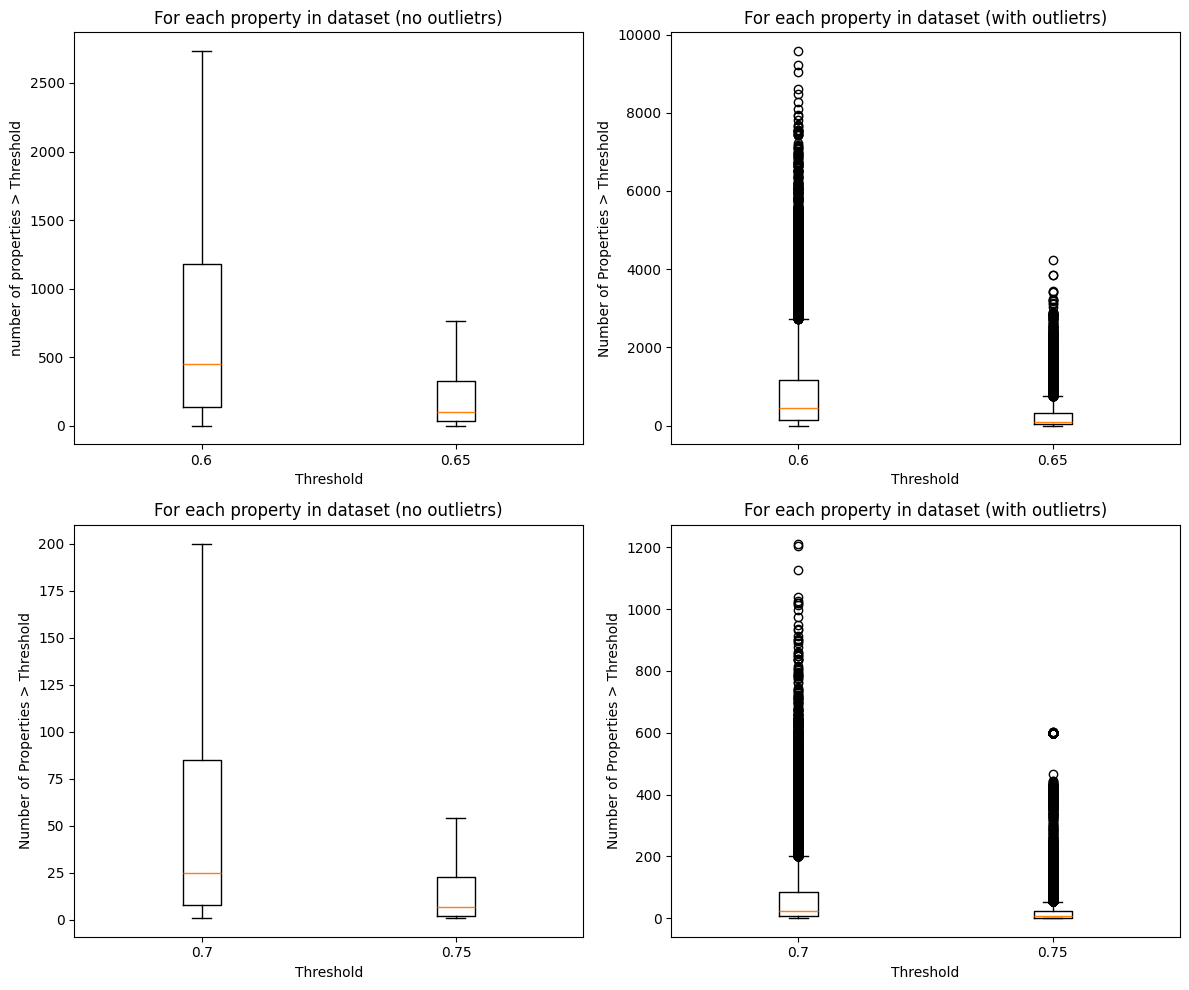

In [35]:
# Function to compute the number of values above each threshold
def compute_n_closest(cos_sim_matrix, thresholds):
    results = {}
    for threshold in thresholds:
        results[threshold] = [(cos_sim_matrix[x, :] > threshold).sum() for x in range(len(cos_sim_matrix))]
    return results

# Define thresholds for the first and second row
thresholds_row1 = [0.6, 0.65]
thresholds_row2 = [0.7, 0.75]

# Compute data for different thresholds
data_row1 = compute_n_closest(cos_sim_matrix, thresholds_row1)
data_row2 = compute_n_closest(cos_sim_matrix, thresholds_row2)

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Boxplots for the first row
axes[0, 0].boxplot([data_row1[threshold] for threshold in thresholds_row1], showfliers=False)
axes[0, 0].set_title('For each property in dataset (no outlietrs)')
axes[0, 0].set_xticklabels(thresholds_row1)
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('number of properties > Threshold')

axes[0, 1].boxplot([data_row1[threshold] for threshold in thresholds_row1])
axes[0, 1].set_title('For each property in dataset (with outlietrs)')
axes[0, 1].set_xticklabels(thresholds_row1)
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Number of Properties > Threshold')

# Boxplots for the second row
axes[1, 0].boxplot([data_row2[threshold] for threshold in thresholds_row2], showfliers=False)
axes[1, 0].set_title('For each property in dataset (no outlietrs)')
axes[1, 0].set_xticklabels(thresholds_row2)
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Number of Properties > Threshold')

axes[1, 1].boxplot([data_row2[threshold] for threshold in thresholds_row2])
axes[1, 1].set_title('For each property in dataset (with outlietrs)')
axes[1, 1].set_xticklabels(thresholds_row2)
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Number of Properties > Threshold')

# Display the plots
plt.tight_layout()
plt.show()

In [46]:
np.mean(data_row2[0.7])

79.90533988698299

In [35]:
cos_sim_matrix

array([[1.        , 0.57314522, 0.88498121, ..., 0.4402459 , 0.2040709 ,
        0.32239866],
       [0.57314522, 1.        , 0.47069983, ..., 0.39763648, 0.30994701,
        0.41240761],
       [0.88498121, 0.47069983, 1.        , ..., 0.36327264, 0.15843578,
        0.29079143],
       ...,
       [0.4402459 , 0.39763648, 0.36327264, ..., 1.        , 0.62824135,
        0.61949717],
       [0.2040709 , 0.30994701, 0.15843578, ..., 0.62824135, 1.        ,
        0.72863014],
       [0.32239866, 0.41240761, 0.29079143, ..., 0.61949717, 0.72863014,
        1.        ]])

In [51]:
np.min(distance_matrix)

-2.220446049250313e-16

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN


distance_matrix = 1 - cos_sim_matrix
distance_matrix = np.clip(distance_matrix, 0, 1)

In [54]:
distance_matrix.shape

(5, 5)

In [ ]:
distance_matrix

In [37]:
import random

def print_top_similarities(cos_sim_matrix, gdf, top_n=10, index_row=None):
    # Randomly select an index
    if index_row is None:
        reference_index = random.randint(0, cos_sim_matrix.shape[0] - 1)
        
    else:
        reference_index = index_row
    
    # Get the indices of the top_n most similar rows (excluding the reference itself)
    similar_indices = np.argsort(cos_sim_matrix[reference_index, :])[-top_n-1:][::-1]
    
    # Display the similarity and description for each similar row
    print(f"Top {top_n} similarities for ", list(gdf[gdf["index_rows"] == reference_index]["clean_description"]))
    for index in similar_indices:
        if index == reference_index:
            continue  
        similarity = cos_sim_matrix[reference_index, index]
        description = list(gdf[gdf["index_rows"] == index]["clean_description"])
        print(f"Similarity: {similarity:.4f}, {description}")

Top 10 similarities for  ["Discover the best of London, with this two bedroom apartment in Clerkenwell.\nwith views over the city.\nIt'll be easy to simply show up and start living in this airy Blueground furnished apartment with its fully-equipped kitchen, comfortable living room, and our dedicated, on-the-ground support.\n(ID #LON418)\n\nGorgeous furniture, fully-equipped kitchen, smart TV, and a premium wireless speaker are just a few of the amenities you'll find inside this two bedroom apartment.\nIdeally located in London, you'll find a lot to love outside as well.\nWhen you're ready to relax, you'll be happy to discover every Blueground bedroom comes with superior quality mattresses, luxury linens, and cozy towels.\nWe handle everything so you can simply show up and start living.\nBuilding amenities unique to this two bedroom apartment include an on-site:\n\nElevator\nWashing machine\n\nSandwiched between the City and the West End, Clerkenwell is where the creative minds of the a

In [42]:
print_top_similarities(cos_sim_matrix, gdf)

Top 10 similarities for  ["Offered to the rental market is this truly breathtaking semi-detached family home located in the sought-after area of Shirley.\nThis recently refurbished property boasts on the ground floor an entrance hall leading to a spacious front reception room, a stunning open plan kitchen/diner perfect for entertaining, a convenient downstairs shower room, a double bedroom , a utility area for added convenience and a sun room.\nUpstairs, you will find a further three generously sized bedrooms, all beautifully presented, as well as a stylish first floor bathroom.In addition to the off-street parking, this property offers a spacious rear garden, perfect for enjoying those summer evenings.\nSituated close to various shops and amenities, excellent transport links, such as the nearby Arena tram stop, and various outdoor spaces including Bywood and South Norwood country park, this home truly offers the best of both worlds.Don't miss out on this fantastic opportunity to make 

In [32]:
print_top_similarities(cos_sim_matrix, gdf)

Top 10 similarities for  ['A beautiful 4 bedroom 4 bathroom duplex penthouse apartment on the 3rd/4th floors of this smart new development.A beautiful 4 bedroom 4 bathroom duplex penthouse apartment on the 3rd/4th floors of this smart new development. The property boasts comfort cooling, integrated WIFI throughout, off street parking for 1 car and use of communal gardens. The property is situated close to the local amenities of Hampstead (Northern Line) and walking distance to Finchley Road (Jubilee Line). Accommodation comprises 3rd floor: reception room, TV room, fully fitted eat in kitchen, 2 bedrooms with 1 en-suite shower room and 1 with en-suite bathroom 4th floor: 2 further bedrooms both with en-suite shower rooms.']
Similarity: 0.9169, ['A beautiful 4 bedroom 4 bathroom duplex penthouse apartment on the 3rd/4th floors of this smart new development. The property boasts comfort cooling, integrated WIFI throughout, off street parking for 1 car and use of communal gardens. The prop

In [24]:
print_top_similarities(cos_sim_matrix, gdf)

Top 10 similarities for  ['This property has been refurbished to a good standard.\xa0 A fully fitted kitchen with all appliances,double bedroom, with access to a gardenThis property is ideally located within a short walkingdistance of Ilford Hill Station which is on the Elizabeth Line, journey into CentralLondon is 20 minutes, walking distance to Ilford Shopping Mall, and localamenities. Additionally, it is close to Valentines Park and local schools,offering both convenience and tranquillity.For more details or to schedule a viewing, please do nothesitate to contact us.Council Tax Band B\xa0 -£1,626 EPC RATING CDEPOSIT £1,350']
Similarity: 0.7048, ['Two bedroom ground floor garden flat. The property benefits from having just gone under a recent full refurbishment with new fitted kitchen and bathroom. New appliances throughout. Spacious lounge. The property also comes with its own private garden. The property is within a short walk to Ilford BR station and gets you to the City and Liver

In [25]:
print_top_similarities(cos_sim_matrix, gdf)

Top 10 similarities for  ['A beautifully presented two double bedroom apartment to let. Situated on the second floor and offering over 790 square feet of lateral living space. Finished to an exceptional standard and with accommodation comprising a bright reception room, a separate fully fitted kitchen, two double bedrooms with fitted wardrobes and a tiled bathroom with bath and shower. Features include neutral décor, contemporary furnishings and wood floors. Located within a short walk of both Baker Street and Marylebone transport links and local amenities as well as the open spaces of Regents Park. Offered furnished and available now. To check broadband and mobile phone coverage please visit Ofcom here ofcom.org.uk/phones-telecoms-and-internet/advice-for-consumers/advice/ofcom-checker']
Similarity: 0.9528, ['A beautifully presented one double bedroom apartment to let. Located on the first floor of a secure development and offering approximately 800 square feet of living space. Accommo

In [26]:
print_top_similarities(cos_sim_matrix, gdf)

Top 10 similarities for  ['The property benefits from two/three big double bedrooms which come part/fully furnished with double beds, wardrobes, chest of drawers, desks and chairs.The separate eat in kitchen comes equipped with all mod cons and a breakfast bar.A fully tiled 2 piece bathroom with a separate WC makes it ideal for those sharing.The property is offered part/fully furnished and comes with laminate and double glazing throughout.Transport Links:14 Minutes Walk to East India Station.12 Minutes Walk to Canning Town Station.20 Minutes Walk to Langdon Park DLR Station.20 Minutes Walk to All Saints Station.Holding Deposit: £507.69']
Similarity: 0.6820, ['Available to market is this immaculately presented top floor(fourth) two double bedroom purpose built apartment located within close proximity to both Langdon Park and Westferry DLR stations.This newly refurbished spacious apartment span in excess of 600 sq ft and is offered unfurnished and benefits from having neutral décor and w

In [27]:
print_top_similarities(cos_sim_matrix, gdf)

Top 10 similarities for  ['***TWO WEEKS RENT FREE IF MOVE IN BY 15TH JAN***\n\nHCGB are proud to present this modern one bed apartment with private garden situated in a desirable development.\n\nChurston Close is a development offering studio, 1 & 2 bedroom properties in the heart of Tulse Hill. Shops and cafes are a short walk away, as is Tulse Hill train station with Brixton a short bus ride away.\n\n\nTenancy:\n\n1. Subject to contract and satisfactory references, the apartment is to be let on an assured shorthold tenancy.\n\n2. The tenant is responsible for the payment of outgoings including council tax, electricity, water and telephone / broadband.\n\n3. A returnable deposit equivalent to 5 weeks rent will be required prior to the commencement of the tenancy. This sum will be returned at the end of the term less any amount for dilapidations or breaches of the terms of the tenancy agreement. The deposit will be held with MyDeposits.']
Similarity: 0.9955, ['***TWO WEEKS RENT FREE IF

In [28]:
print_top_similarities(cos_sim_matrix, gdf, index_row=662)

Top 10 similarities for  ['Available from the beginning of January 2025 (Furnished)Cosy two bedroom flat located on the third floor (with lift) within a gated development minutes away from Hammersmith Station. Which will be freshly painted throughout.The flat comprises of two bedrooms, one bathroom, reception room, separate fully fitted kitchen, ample storage space. The building offers many benefits from 24 hour porter and security, gated development and heating and hot water included in rent. Walking distance from many local amenities and Hammersmith Underground Station.Rent: £2250 per calendar monthSecurity Deposit: £2595 (Five Weeks)EPC band - CCouncil tax band - D']
Similarity: 0.8464, ['Available from the beginning of January 2025 (Furnished)This lovely two bedroom apartment on the 6th floor located in a sought after gated development minutes away from Hammersmith station.The apartment consists of two bedrooms, one bathroom, a reception room and a separate fully fitted kitchen. Th

In [29]:
print_top_similarities(cos_sim_matrix, gdf, index_row=21795)

Top 10 similarities for  ['Houseen Property are pleased to present this contemporary three-bedroom apartment, located in The Tannery, part of the highly sought-after London Square Bermondsey development in SE1.This stylish, fully furnished apartment offers an open-plan kitchen and living area, featuring large windows that flood the space with natural light, high ceilings, and generous storage throughout. The property also benefits from a private balcony with sweeping views of the London skyline, luxurious modern bathrooms, and hardwood flooring throughout.Key Features:-Three spacious bedrooms-Open-plan kitchen and living space-Large windows & high ceilings, providing a bright and airy atmosphere-Private balcony with stunning city views-Beautiful wooden flooring throughout-Stylish, contemporary bathrooms-Ample storage spaceLocation: Bermondsey offers fantastic transport links, with London Bridge and Tower Bridge both easily accessible. The apartment is just an 8-minute walk from the vib

Embed. dim. can be reduced from the original of 384 to 200, while retaining = 95 % of the explained varience in the dataset


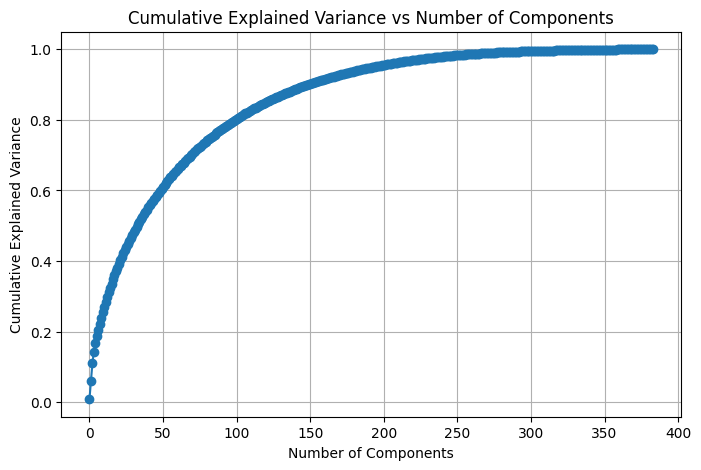

In [30]:


svd = TruncatedSVD(n_components=embed_matrix.shape[1])  
X_reduced = svd.fit_transform(embed_matrix)

# Get the explained variance ratio for each component
explained_variance = svd.explained_variance_ratio_

# Calculate the cumulative sum of explained variance
cumulative_explained_variance = np.cumsum(explained_variance)
print("Embed. dim. can be reduced from the original of 384 to 200, while retaining = {} % of the explained varience in the dataset".format(round(cumulative_explained_variance[199]*100),1))

plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()



### The way the data was downloaded borough by borough, it needs reshuflling before modelling

In [36]:
gdf["borough"] # Current 

id
154825190    Hammersmith and Fulham
155893427    Hammersmith and Fulham
154825184    Hammersmith and Fulham
154274906    Hammersmith and Fulham
152063288    Hammersmith and Fulham
                      ...          
156015842                     Brent
152958695                     Brent
152955419                     Brent
147232748                     Brent
155503607                     Brent
Name: borough, Length: 29907, dtype: object

In [39]:
shuffled_df = gdf.sample(frac=1).reset_index(drop=False)

In [40]:
shuffled_df["borough"] # After reshuflle

0                      Hounslow
1                        Ealing
2                     Southwark
3                    Wandsworth
4                     Islington
                  ...          
29902    Kensington and Chelsea
29903                Wandsworth
29904      Kingston upon Thames
29905               Westminster
29906                    Barnet
Name: borough, Length: 29907, dtype: object

In [41]:
shuffled_df.to_parquet("../data/processed/eda2.parquet")